In this approach, the trajectories are centered to the mean as the origin. Then, they are converted to point clouds by transforming the temporal dimension into a spatial dimension. Later, the Euclidean Distances Matrix (EDM) is computed for each point clouds. Since the EDM contains redundant information, the non-redundant vector is used as the feature for the Hierarchical Agglomerative Clustering (HAC). 

In [1]:
import pandas as pd
import numpy as np
import ast 

# Redefining the conversion function to produce a list of lists of integers
def convert_to_list_of_lists(array_str):
    # Remove the 'array' and surrounding brackets
    array_str = array_str.replace('array(', '').replace(')', '')
    # Use ast.literal_eval to safely evaluate the string as a Python expression
    evaluated = ast.literal_eval(array_str)
    # Convert the tuples of arrays into lists of lists
    return [list(arr) for arr in evaluated]

df = pd.read_csv('Traj_Results.csv')
df['traj'] = df['traj'].astype(str).apply(convert_to_list_of_lists)
df['traj'] = df['traj'].apply(lambda x: np.array(x))
df['centered_traj'] = df['traj'].apply(lambda x: np.array([sub_array - sub_array.mean() for sub_array in x]))
df.head()

,Unnamed: 0,name,date,quantity,exposure,tracked_id,traj,VCL,VAP,VSL,LIN,STR,WOB,BeatCross,ALH,img,cluster,centered_traj
0,0,Balder,03032020_1,0,0m,1.0,"[[217, 217, 218, 217, 217, 218, 217, 217, 217,...",60.816720,26.542675,24.077578,0.395904,0.907127,0.436437,49.024390,2.507319,[1. 1. 1. ... 1. 1. 1.],0,"[[4.764705882352928, 4.764705882352928, 5.7647..."
1,1,Balder,03032020_1,0,0m,2.0,"[[547, 547, 546, 547, 547, 546, 548, 547, 547,...",65.542230,34.366753,25.329240,0.386457,0.737027,0.524345,45.494507,2.760374,[1. 1. 1. ... 1. 1. 1.],0,"[[12.287234042553223, 12.287234042553223, 11.2..."
2,2,Balder,03032020_1,0,0m,3.0,"[[261, 261, 261, 261, 261, 261, 261, 261, 260,...",69.336380,44.143960,28.248203,0.407408,0.639911,0.636664,39.428570,2.817186,[1. 1. 1. ... 1. 1. 1.],0,"[[10.794520547945211, 10.794520547945211, 10.7..."
3,3,Balder,03032020_1,0,0m,7.0,"[[608, 608, 608, 608, 608, 608, 608, 608, 608,...",52.817290,14.678791,11.211498,0.212269,0.763789,0.277916,47.256638,1.513670,[1. 1. 1. ... 1. 1. 1.],0,"[[6.865546218487339, 6.865546218487339, 6.8655..."
4,4,Balder,03032020_1,0,0m,8.0,"[[140, 140, 142, 142, 144, 143, 146, 146, 147,...",110.559395,76.505140,63.407223,0.573513,0.828797,0.691982,25.945946,4.752110,[1. 1. 1. ... 1. 1. 1.],0,"[[-9.699999999999989, -9.699999999999989, -7.6..."


In [2]:
#reduced_df = df.sample(n=1000, random_state=42)

In [2]:
i_traj = df["centered_traj"].values
c_traj = [element.transpose().tolist() for element in i_traj]
df["centered_traj"] = c_traj

In [3]:
len(df)

38300

In [4]:
def trajectory_to_point_cloud(c_traj):
    c_pc = []  # Initialize the list to store point clouds

    for traj in c_traj:
        n_points = len(traj)  # Number of points in the trajectory
        # Generate interpolated z-axis values from 1 to -1
        z_values = [1 - 2*i/(n_points-1) if n_points > 1 else 0 for i in range(n_points)]

        # Create the point cloud for the current trajectory
        point_cloud = [traj[i] + [z_values[i]] for i in range(n_points)]

        # Append the current point cloud to the list of point clouds
        c_pc.append(point_cloud)

    return c_pc

c_pc = trajectory_to_point_cloud(c_traj)
print(c_pc[0])


[[4.764705882352928, -9.258823529411766, 1.0], [4.764705882352928, -9.258823529411766, 0.9761904761904762], [5.764705882352928, -9.258823529411766, 0.9523809523809523], [4.764705882352928, -9.258823529411766, 0.9285714285714286], [4.764705882352928, -9.258823529411766, 0.9047619047619048], [5.764705882352928, -8.258823529411766, 0.8809523809523809], [4.764705882352928, -9.258823529411766, 0.8571428571428572], [4.764705882352928, -8.258823529411766, 0.8333333333333334], [4.764705882352928, -9.258823529411766, 0.8095238095238095], [3.764705882352928, -8.258823529411766, 0.7857142857142857], [4.764705882352928, -8.258823529411766, 0.7619047619047619], [4.764705882352928, -9.258823529411766, 0.7380952380952381], [3.764705882352928, -8.258823529411766, 0.7142857142857143], [4.764705882352928, -8.258823529411766, 0.6904761904761905], [3.764705882352928, -8.258823529411766, 0.6666666666666667], [4.764705882352928, -8.258823529411766, 0.6428571428571428], [4.764705882352928, -8.258823529411766

In [5]:
np.asarray(c_pc[1]).shape

(94, 3)

In [6]:
from scipy.interpolate import interp1d

def interpolate_point_clouds(c_pc, target_length):
    interpolated_c_pc = []

    for pc in c_pc:
        # Convert point cloud to numpy array for easier manipulation
        pc_array = np.asarray(pc)
        # Get the original length of the point cloud
        original_length = pc_array.shape[0]
        # Create an array representing the original indices
        original_indices = np.arange(original_length)
        # Create an array representing the target indices for interpolation
        target_indices = np.linspace(0, original_length - 1, target_length)

        # Interpolate x, y, and z coordinates
        interp_x = interp1d(original_indices, pc_array[:, 0], kind='linear')(target_indices)
        interp_y = interp1d(original_indices, pc_array[:, 1], kind='linear')(target_indices)
        interp_z = interp1d(original_indices, pc_array[:, 2], kind='linear')(target_indices)

        # Combine the interpolated coordinates
        interpolated_pc = np.vstack((interp_x, interp_y, interp_z)).T

        # Append the interpolated point cloud to the list
        interpolated_c_pc.append(interpolated_pc)

    return interpolated_c_pc

target_length = 25
# Interpolate the point clouds to have the same length
interpolated_c_pc = interpolate_point_clouds(c_pc, target_length)

In [7]:
print(np.asarray(interpolated_c_pc[0]).shape)
print(np.asarray(interpolated_c_pc[1]).shape)

(25, 3)
(25, 3)


In [8]:
from scipy.spatial import distance_matrix

def calculate_distance_matrices(interpolated_c_pc):
    distance_matrices = []

    for pc in interpolated_c_pc:
        # Convert point cloud to numpy array if it's not already
        pc_array = np.asarray(pc)
        # Calculate the Euclidean distance matrix for the current point cloud
        dist_matrix = distance_matrix(pc_array, pc_array)
        # Append the distance matrix to the list
        distance_matrices.append(dist_matrix)

    return distance_matrices

# Calculate the Euclidean distance matrices for the interpolated point clouds
distance_matrices = calculate_distance_matrices(interpolated_c_pc)

# Example usage to check the shape of one of the distance matrices
print(distance_matrices[0].shape)


(25, 25)


In [9]:
def extract_non_redundant_vectors(distance_matrices):
    non_redundant_vectors = []

    for matrix in distance_matrices:
        # Extract the upper triangular part of the matrix, excluding the diagonal
        upper_triangular = matrix[np.triu_indices_from(matrix, k=1)]
        # Append the non-redundant vector to the list
        non_redundant_vectors.append(upper_triangular)

    return non_redundant_vectors

# Extract the non-redundant vectors from the distance matrices
non_redundant_vectors = extract_non_redundant_vectors(distance_matrices)

# Example usage to check the shape of one of the non-redundant vectors
print(non_redundant_vectors[0].shape)


(300,)


In [11]:
num_c = 9 # Adjust based on your requirements or analysis


In [12]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Assuming list_angles is a flat list of angles
# Reshape list_angles to be a 2D array, as required by AgglomerativeClustering
#angles_array = np.array(list_angles).reshape(-1, 1)

# Initialize the AgglomerativeClustering model
# The number of clusters, n_clusters, is required. Adjust it based on your needs.
# linkage='ward' is a common choice that minimizes the variance of clusters being merged.
hac = AgglomerativeClustering(n_clusters=num_c, affinity='euclidean', linkage='ward')

# Fit the model to your data
hac.fit(np.asarray(non_redundant_vectors))

# Get the cluster labels for each angle
labels = hac.labels_

/home/rodriguez/miniconda3/envs/traj/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [13]:
df['HAC_cluster'] = labels

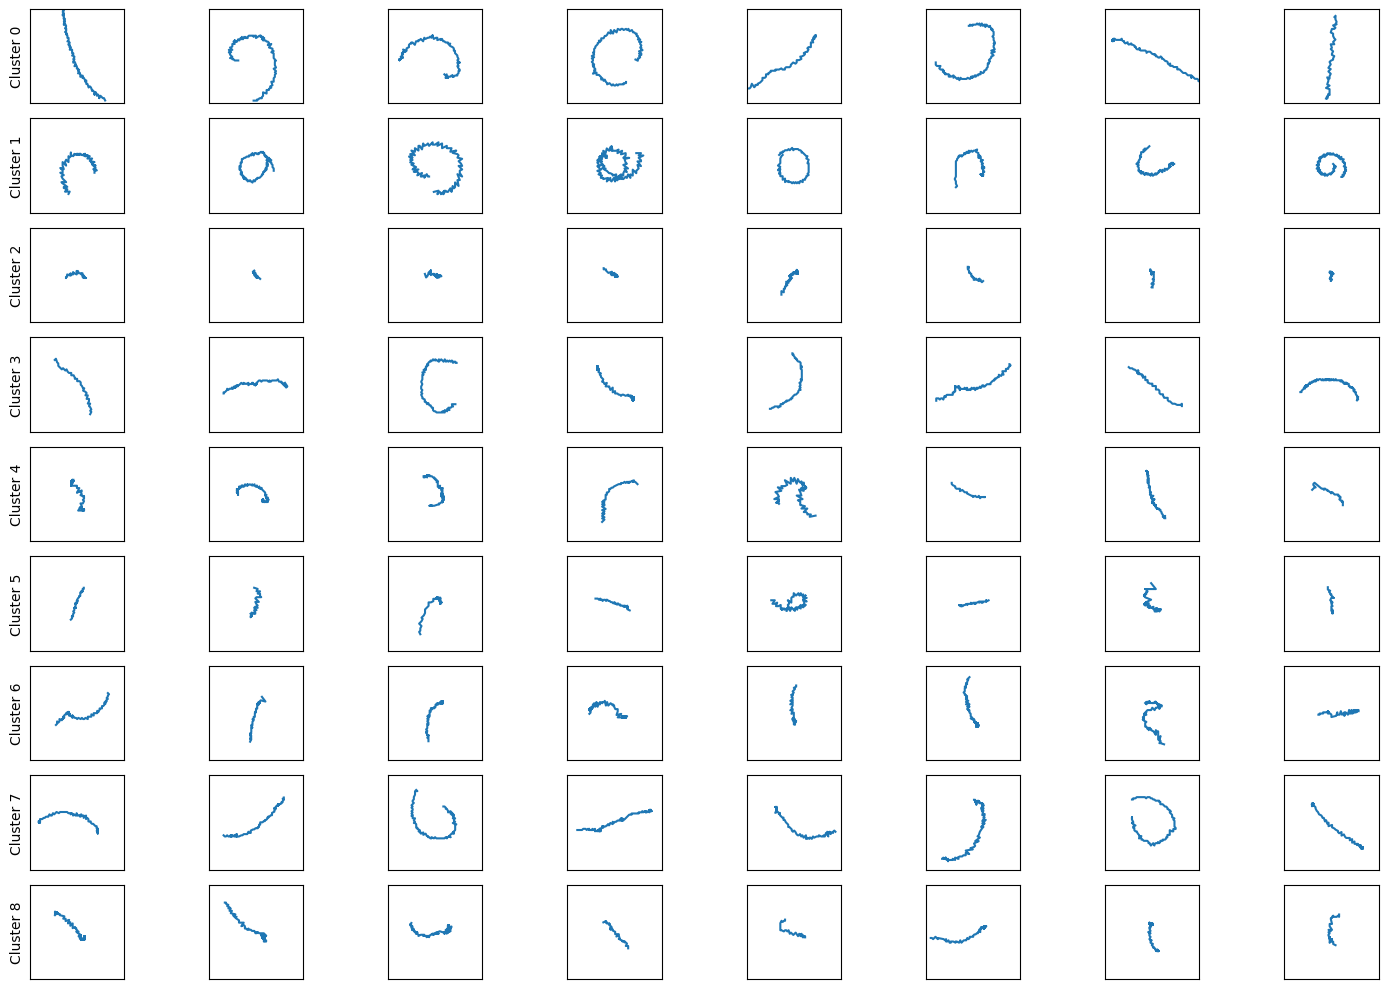

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast


n_samples = 8
# Create a figure with subplots
fig, axes = plt.subplots(num_c, n_samples, figsize=(15, 10))  # Adjust the size as needed

for i in range(num_c):
    # Select random samples from each cluster
    cluster_data = df[df['HAC_cluster'] == i].sample(n=n_samples, random_state=42)
    
    for j, (index, row) in enumerate(cluster_data.iterrows()):
        ax = axes[i][j]
        # Extract the centered trajectory
        traj_array = np.array(row['centered_traj'])
        # Plot the trajectory
        ax.plot(traj_array[:, 0], traj_array[:, 1])

        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        ax.set_aspect('equal', adjustable='box')

        # Optional: Hide x and y axis labels for clarity
        ax.set_xticks([])
        ax.set_yticks([])

    # Set y-axis label for each row
    axes[i][0].set_ylabel(f"Cluster {i}")

# Optional: adjust layout for better spacing
plt.tight_layout()
plt.show()

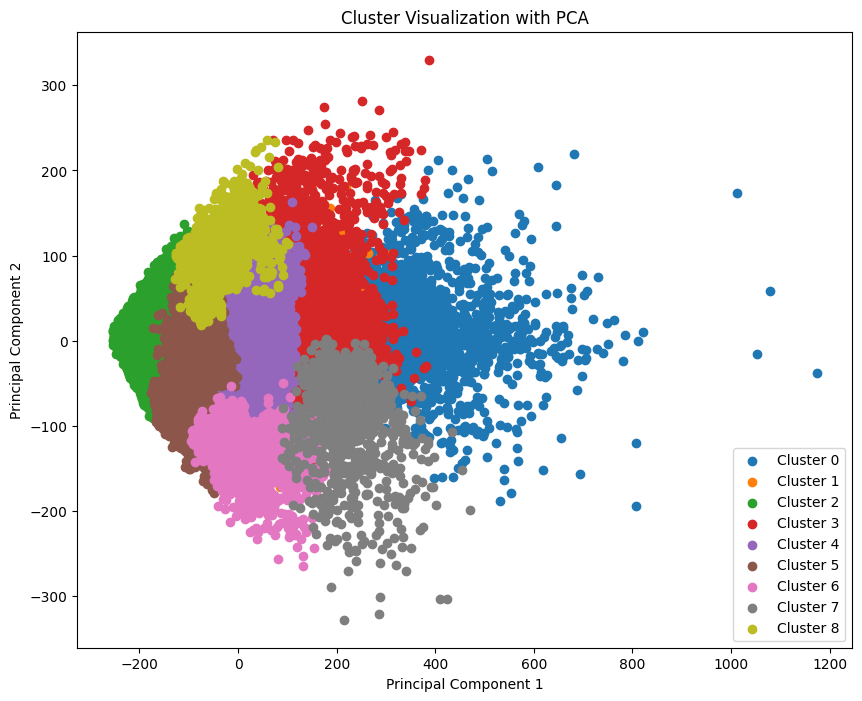

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'features' are your motility parameters
# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(non_redundant_vectors)

# Plot
plt.figure(figsize=(10, 8))
for cluster in range(num_c):  
    cluster_data = reduced_features[df['HAC_cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


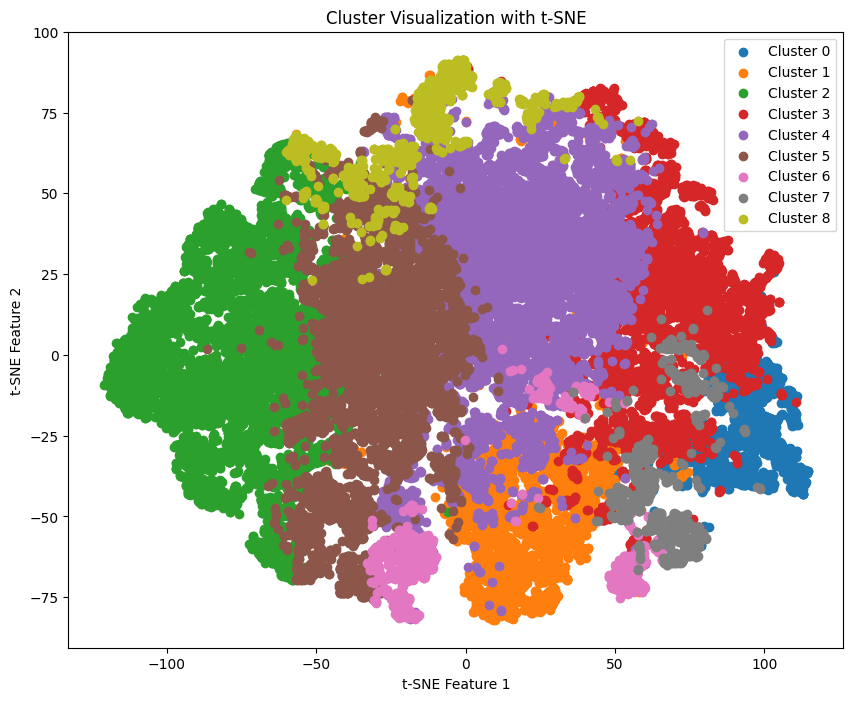

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'features' are your motility parameters
# Perform t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)  # random_state for reproducibility
reduced_features = tsne.fit_transform(np.asarray(non_redundant_vectors))

# Plot
plt.figure(figsize=(10, 8))
for cluster in range(num_c):  # Assuming there are 4 clusters
    cluster_data = reduced_features[df['HAC_cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

plt.title('Cluster Visualization with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()


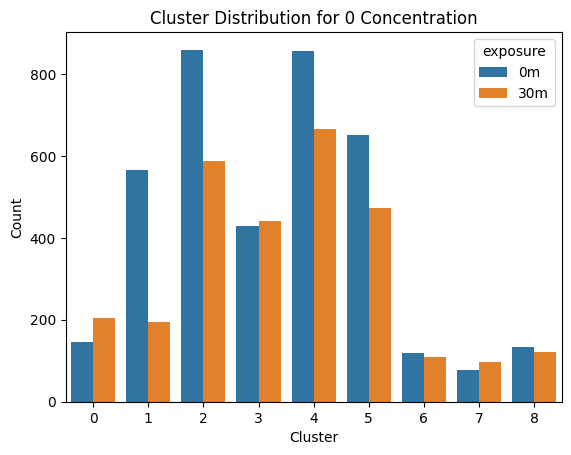

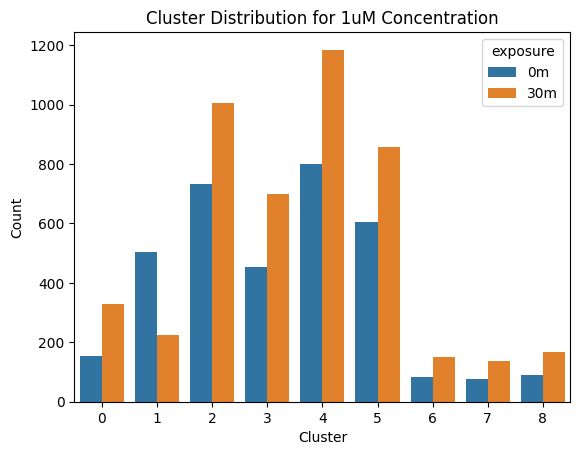

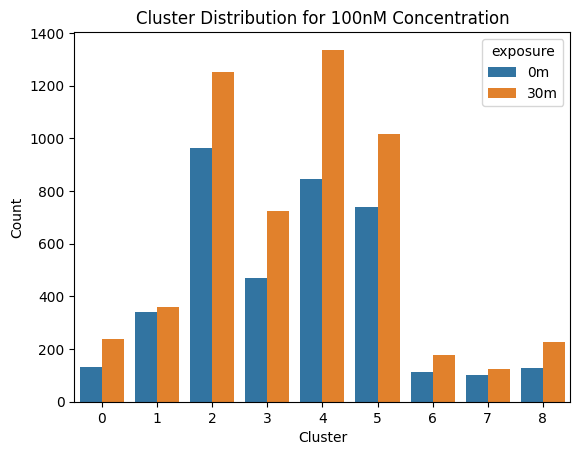

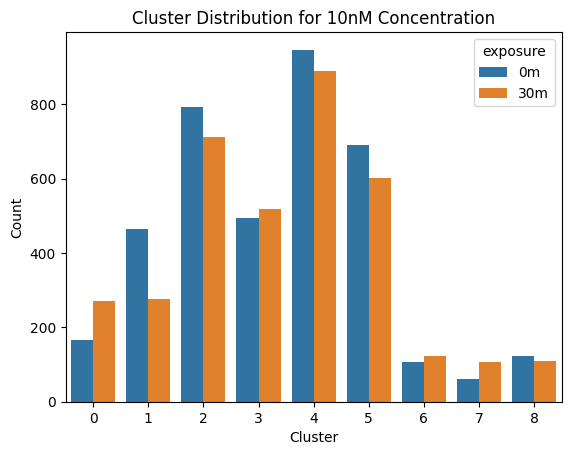

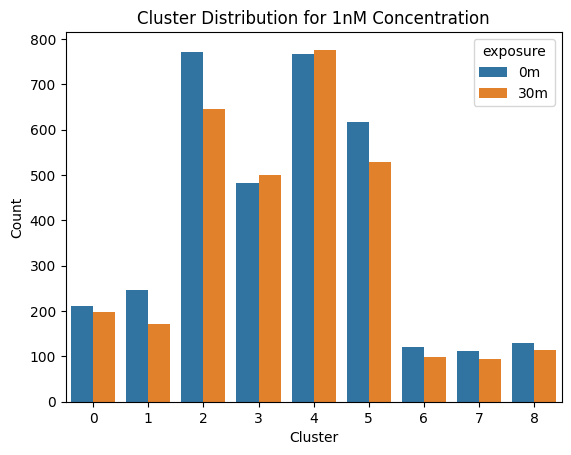

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of clusters at different time points for each concentration
def plot_cluster_distribution(df):
    for concentration in df['quantity'].unique():
        subset = df[df['quantity'] == concentration]
        sns.countplot(x='HAC_cluster', hue='exposure', data=subset)
        plt.title(f'Cluster Distribution for {concentration} Concentration')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.show()

plot_cluster_distribution(df)

In [19]:
df['quantity'].unique()

array(['0', '1uM', '100nM', '10nM', '1nM'], dtype=object)

In [20]:
df['exposure'].unique()

array(['0m', '30m'], dtype=object)

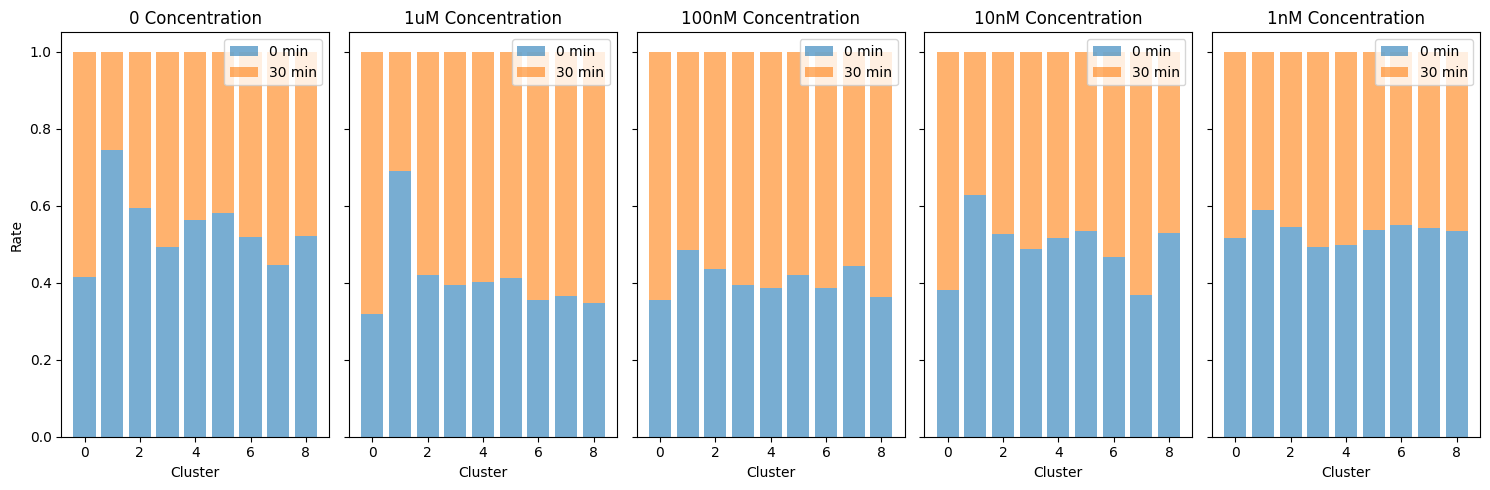

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot rate of elements in each cluster
def plot_cluster_rate(df, num_c):
    # Get unique concentrations
    concentrations = df['quantity'].unique()
    clusters = range(num_c)  # Assuming num_c is the number of clusters

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(concentrations), figsize=(15, 5), sharey=True)

    for i, concentration in enumerate(concentrations):
        subset = df[df['quantity'] == concentration]
        total = subset.groupby(['HAC_cluster'])['exposure'].count()

        # Calculate rate (proportion) of elements in each cluster at 0 and 30 minutes
        rate_0 = subset[subset['exposure'] == '0m'].groupby(['HAC_cluster'])['exposure'].count() / total
        rate_30 = subset[subset['exposure'] == '30m'].groupby(['HAC_cluster'])['exposure'].count() / total

        # Create bar plot for each concentration
        axes[i].bar(clusters, rate_0, label='0 min', alpha=0.6)
        axes[i].bar(clusters, rate_30, bottom=rate_0, label='30 min', alpha=0.6)
        axes[i].set_title(f'{concentration} Concentration')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel('Rate' if i == 0 else '')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_cluster_rate(df, num_c)  # Assuming num_c is the number of clusters


In [22]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# List of motility parameters
motility_parameters = ['VCL', 'VAP', 'VSL', 'LIN', 'STR', 'WOB', 'BeatCross', 'ALH']

# ANOVA for each motility parameter within each cluster
anova_results = {}
for cluster in df['HAC_cluster'].unique():
    cluster_data = df[df['HAC_cluster'] == cluster]
    anova_results_cluster = {}

    for param in motility_parameters:
        model = ols(f'{param} ~ C(quantity) * C(exposure)', data=cluster_data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results_cluster[param] = anova_table

    anova_results[cluster] = anova_results_cluster

# Output ANOVA results
for cluster, results in anova_results.items():
    print(f'ANOVA results for Cluster {cluster}:')
    for param, result in results.items():
        print(f'ANOVA for {param}:')
        print(result)
        print()  # Adding a blank line for better readability

ANOVA results for Cluster 5:
ANOVA for VCL:
                               sum_sq      df           F        PR(>F)
C(quantity)              5.436133e+04     4.0   15.075647  2.839221e-12
C(exposure)              1.208329e+05     1.0  134.038915  1.041543e-30
C(quantity):C(exposure)  2.405425e+04     4.0    6.670796  2.356245e-05
Residual                 6.101189e+06  6768.0         NaN           NaN

ANOVA for VAP:
                               sum_sq      df         F        PR(>F)
C(quantity)              1.198599e+04     4.0  8.861413  3.920882e-07
C(exposure)              8.439814e+00     1.0  0.024959  8.744747e-01
C(quantity):C(exposure)  4.641275e+03     4.0  3.431361  8.267632e-03
Residual                 2.288607e+06  6768.0       NaN           NaN

ANOVA for VSL:
                               sum_sq      df          F    PR(>F)
C(quantity)              1.020958e+04     4.0   8.019347  0.000002
C(exposure)              5.184303e+03     1.0  16.288511  0.000055
C(quantity):C

In [23]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy.contrasts import Helmert

# ANOVA with Helmert contrasts for each motility parameter within each cluster
anova_results = {}
for cluster in df['HAC_cluster'].unique():
    cluster_data = df[df['HAC_cluster'] == cluster]
    anova_results_cluster = {}

    for param in motility_parameters:
        # Fitting the model with Helmert contrasts
        formula = f'{param} ~ C(quantity, Helmert()) * C(exposure)'
        model = ols(formula, data=cluster_data).fit()

        # Calculating ANOVA table with contrasts
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results_cluster[param] = anova_table

    anova_results[cluster] = anova_results_cluster

# Output ANOVA results
for cluster, results in anova_results.items():
    print(f'ANOVA results for Cluster {cluster}:')
    for param, result in results.items():
        print(f'ANOVA for {param} with Helmert Contrasts:')
        print(result)
        print()  # Adding a blank line for better readability


ANOVA results for Cluster 5:
ANOVA for VCL with Helmert Contrasts:
                                          sum_sq      df           F  \
C(quantity, Helmert())              5.436133e+04     4.0   15.075647   
C(exposure)                         1.208329e+05     1.0  134.038915   
C(quantity, Helmert()):C(exposure)  2.405425e+04     4.0    6.670796   
Residual                            6.101189e+06  6768.0         NaN   

                                          PR(>F)  
C(quantity, Helmert())              2.839221e-12  
C(exposure)                         1.041543e-30  
C(quantity, Helmert()):C(exposure)  2.356245e-05  
Residual                                     NaN  

ANOVA for VAP with Helmert Contrasts:
                                          sum_sq      df         F  \
C(quantity, Helmert())              1.198599e+04     4.0  8.861413   
C(exposure)                         8.439814e+00     1.0  0.024959   
C(quantity, Helmert()):C(exposure)  4.641275e+03     4.0  3.431361  

In [24]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming 'df' is your DataFrame and it includes 'HAC_cluster', 'quantity', and motility parameters

# Loop through each cluster
for cluster in df['HAC_cluster'].unique():
    print(f"Cluster {cluster} Analysis:\n")
    cluster_data = df[df['HAC_cluster'] == cluster]
    
    # Loop through each motility parameter
    for param in motility_parameters:
        print(f"Post-hoc Analysis for {param}:\n")
        
        # Fit the model
        model = ols(f'{param} ~ C(quantity)', data=cluster_data).fit()
        
        # Perform ANOVA
        anova_results = sm.stats.anova_lm(model, typ=2)
        
        # Display ANOVA table
        print("ANOVA Table:")
        print(anova_results)
        print("\n")
        
        # Tukey's HSD post-hoc test for pairwise comparisons
        tukey = pairwise_tukeyhsd(endog=cluster_data[param],     # Data
                                  groups=cluster_data['quantity'],   # Groups
                                  alpha=0.05)                   # Significance level

        # Display Tukey's test results
        print("Tukey's HSD Results:")
        print(tukey)
        print("\n" + "-"*50 + "\n")


Cluster 5 Analysis:

Post-hoc Analysis for VCL:

ANOVA Table:
                   sum_sq      df          F        PR(>F)
C(quantity)  4.304480e+04     4.0  11.669023  1.916932e-09
Residual     6.246077e+06  6773.0        NaN           NaN




Tukey's HSD Results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0  100nM   0.4105 0.9967  -2.7565  3.5776  False
     0   10nM  -3.6659 0.0256  -7.0446 -0.2873   True
     0    1nM  -6.4904    0.0  -9.9703 -3.0105   True
     0    1uM  -0.8977 0.9458  -4.1855  2.3901  False
 100nM   10nM  -4.0765 0.0023  -7.1126 -1.0403   True
 100nM    1nM  -6.9009    0.0 -10.0493 -3.7525   True
 100nM    1uM  -1.3083 0.7419   -4.243  1.6265  False
  10nM    1nM  -2.8244 0.1472  -6.1856  0.5368  False
  10nM    1uM   2.7682 0.1184  -0.3937  5.9301  False
   1nM    1uM   5.5926    0.0   2.3228  8.8625   True
-----------------------------------------------------

--------------------------------------------------

Post-hoc Analysis for VAP:

ANOVA Table:
                   sum_sq      df         F        PR(>F)
C(quantity)  1.208574e+04     4.0  8.923629  3.487178e-07
Residual     